In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# ============================================================
# Read and merge all yearly US index files (2005–2025)
# ============================================================
csv_files = [
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2005.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2006.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2007.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2008.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2009.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2010.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2011.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2012.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2013.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2014.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2015.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2016.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2017.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2018.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2019.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2020.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2021.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2022.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2023.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2024.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2025.csv",
]

all_dfs = []
for fp in csv_files:
    df = pd.read_csv(fp)
    df["source_file"] = os.path.basename(fp)
    all_dfs.append(df)

merged_full_df = pd.concat(all_dfs, ignore_index=True)
out_merged = "Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_merged.csv"
merged_full_df.to_csv(out_merged, index=False)
print(f"✅ Merged {len(csv_files)} files → {out_merged}")
print(f"   Total rows: {len(merged_full_df):,}")


✅ Merged 21 files → Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_merged.csv
   Total rows: 7,157,595


In [32]:
# ============================================================
# Keep only Fridays and normalize columns
# ============================================================
def keep_fridays(df: pd.DataFrame):
    """Detect date column, parse, and keep only Fridays."""
    date_col = None
    for cand in ["Trddt", "Date", "date", "DATE"]:
        if cand in df.columns:
            date_col = cand
            break
    if date_col is None:
        raise ValueError("No date column found (expected one of: Trddt, Date, date, DATE).")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col])
    df = df[df[date_col].dt.weekday == 4].copy()  # 4 = Friday
    return df, date_col

friday_parts = []
rows_before, rows_after = 0, 0

for fp in csv_files:
    tmp = pd.read_csv(fp)
    rows_before += len(tmp)
    tmp, dt_col = keep_fridays(tmp)
    tmp["source_file"] = os.path.basename(fp)
    rows_after += len(tmp)
    friday_parts.append(tmp)
    print(f"✔ {os.path.basename(fp)}: {len(tmp):,} Friday rows")

friday_df = pd.concat(friday_parts, ignore_index=True)

# keep useful columns if they exist
keep_cols = [c for c in ["Indexcd", "IndexName", "Clsidx", dt_col, "source_file"] if c in friday_df.columns]
friday_df = friday_df[keep_cols]

out_fridays = "Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_FRIDAYS_merged.csv"
friday_df.to_csv(out_fridays, index=False)

print("\n✅ Friday-only merge complete.")
print(f"   Rows before filter: {rows_before:,}")
print(f"   Rows after filter:  {rows_after:,}")
print(f"   Output: {out_fridays}")


✔ TRDA_Gidxtrd_2005.csv: 39,874 Friday rows
✔ TRDA_Gidxtrd_2006.csv: 77,199 Friday rows
✔ TRDA_Gidxtrd_2007.csv: 74,692 Friday rows
✔ TRDA_Gidxtrd_2008.csv: 109,679 Friday rows
✔ TRDA_Gidxtrd_2009.csv: 121,857 Friday rows
✔ TRDA_Gidxtrd_2010.csv: 116,933 Friday rows
✔ TRDA_Gidxtrd_2011.csv: 120,666 Friday rows
✔ TRDA_Gidxtrd_2012.csv: 122,046 Friday rows
✔ TRDA_Gidxtrd_2013.csv: 122,470 Friday rows
✔ TRDA_Gidxtrd_2014.csv: 113,143 Friday rows
✔ TRDA_Gidxtrd_2015.csv: 112,220 Friday rows
✔ TRDA_Gidxtrd_2016.csv: 115,264 Friday rows
✔ TRDA_Gidxtrd_2017.csv: 104,535 Friday rows
✔ TRDA_Gidxtrd_2018.csv: 40,131 Friday rows
✔ TRDA_Gidxtrd_2019.csv: 1,887 Friday rows
✔ TRDA_Gidxtrd_2020.csv: 1,814 Friday rows
✔ TRDA_Gidxtrd_2021.csv: 1,887 Friday rows
✔ TRDA_Gidxtrd_2022.csv: 1,888 Friday rows
✔ TRDA_Gidxtrd_2023.csv: 1,885 Friday rows
✔ TRDA_Gidxtrd_2024.csv: 1,815 Friday rows
✔ TRDA_Gidxtrd_2025.csv: 1,517 Friday rows

✅ Friday-only merge complete.
   Rows before filter: 7,157,595
   Rows a

In [33]:
# ============================================================
# Add ISO year/week (YYYY-WW) to match China format
# ============================================================
date_col = "Trddt" if "Trddt" in friday_df.columns else "Date"
friday_df[date_col] = pd.to_datetime(friday_df[date_col], errors="coerce")

iso = friday_df[date_col].dt.isocalendar()
friday_df["Year"] = iso["year"].astype(int)
friday_df["Week"] = iso["week"].astype(int)
friday_df["Date"] = friday_df["Year"].astype(str) + "-" + friday_df["Week"].astype(str).str.zfill(2)

friday_df = friday_df.sort_values([date_col]).reset_index(drop=True)

out_fridays_yw = "Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_FRIDAYS_with_YW.csv"
friday_df.to_csv(out_fridays_yw, index=False)
print(f"✅ Saved Friday file with YYYY-WW: {out_fridays_yw}")

✅ Saved Friday file with YYYY-WW: Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_FRIDAYS_with_YW.csv


In [40]:
# ============================================================
# Flexible search function for index names
# ============================================================

def search_index(df, keyword: str):
    """
    Search for indices whose names contain the given keyword.
    Prints all matching variants and returns the filtered DataFrame.
    """
    mask = df["IndexName"].str.contains(keyword, case=False, na=False)
    results = df[mask].copy()

    unique_names = sorted(results["IndexName"].dropna().unique())
    print(f"🔍 Search keyword: '{keyword}'")
    print(f"   → Total matches: {len(results):,}")
    print(f"   → Unique name variants: {len(unique_names)}")
    for n in unique_names:
        print(f"     • {n}")

    return results


# Example usage:
nasdaq_composite_df = search_index(friday_df, "NQ|Nasdaq")

🔍 Search keyword: 'NQ|Nasdaq'
   → Total matches: 13,113
   → Unique name variants: 13
     • NASDAQ Health Care
     • NQ Bank
     • NQ Biotechnology
     • NQ Computer
     • NQ Financial 100
     • NQ Industrial
     • NQ Insurance
     • NQ Internet
     • NQ Other Finance
     • NQ Telecommunications
     • NQ Transportation
     • Nasdaq
     • Nasdaq 100


In [34]:
# ============================================================
# Map index names → index codes for a given list
# ============================================================
index_names = [
    "Nasdaq 100",
    "NQ Telecommunications",
    "NASDAQ Health Care",
    "NQ Transportation",
    "NQ Internet",
    "NQ Computer",
    "Nasdaq",
    "NQ Industrial",
    "NQ Biotechnology",
]

indexcd_map = (
    friday_df[friday_df["IndexName"].isin(index_names)]
    .groupby("IndexName")["Indexcd"]
    .unique()
    .reset_index()
)

indexcd_map["Indexcd"] = indexcd_map["Indexcd"].apply(lambda x: ", ".join(map(str, x)))
display(indexcd_map)


,IndexName,Indexcd
0,NASDAQ Health Care,IXHC
1,NQ Biotechnology,NBI
2,NQ Computer,IXK
3,NQ Industrial,IXID
4,NQ Internet,QNET
5,NQ Telecommunications,IXUT
6,NQ Transportation,IXTR
7,Nasdaq,IXIC
8,Nasdaq 100,NDX


In [35]:
# ============================================================
# Weekly log returns per index (US data)
# ============================================================
us_weekly = friday_df[["Indexcd", "IndexName", "Date", "Clsidx"]].copy()

# split YYYY-WW → year/week and create actual week start (Monday)
us_weekly[["Year", "Week"]] = us_weekly["Date"].astype(str).str.split("-", expand=True).astype(int)
us_weekly["WeekStart"] = us_weekly.apply(
    lambda r: pd.Timestamp.fromisocalendar(int(r["Year"]), int(r["Week"]), 1),
    axis=1,
)

us_weekly = us_weekly.sort_values(["Indexcd", "Year", "Week"])
us_weekly["Clsidx"] = pd.to_numeric(us_weekly["Clsidx"], errors="coerce")

# log return by index
us_weekly["LogReturn"] = np.log(us_weekly["Clsidx"]).groupby(us_weekly["Indexcd"]).diff()
us_weekly["CumLogReturn"] = us_weekly.groupby("Indexcd")["LogReturn"].cumsum()


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# ============================================================
# Helper functions to detect missing weeks (for US / friday_df)
# We assume friday_df["Date"] is in ISO-like form 'YYYY-WW'
# ============================================================
def expected_weeks_between(min_year: int, max_year: int):
    """Return list of all ISO year-week strings between two years."""
    weeks = []
    for y in range(min_year, max_year + 1):
        # ISO calendar: some years have 53 weeks
        weeks_in_year = 53 if pd.Timestamp(f"{y}-12-31").isocalendar()[1] == 53 else 52
        weeks += [f"{y}-{str(w).zfill(2)}" for w in range(1, weeks_in_year + 1)]
    return weeks


def missing_weeks_df_us(df: pd.DataFrame, label: str = None) -> pd.DataFrame:
    """
    Detect missing ISO weeks for one US index slice (from friday_df).
    Expects columns: Date (YYYY-WW), IndexName, Indexcd.
    """
    if df.empty:
        return pd.DataFrame(columns=[
            "IndexName", "IndexCode", "Year", "Week",
            "YearWeek", "WeekStart", "Month"
        ])

    tmp = df.copy()
    tmp[["Year", "Week"]] = tmp["Date"].astype(str).str.split("-", expand=True).astype(int)

    min_year, max_year = tmp["Year"].min(), tmp["Year"].max()
    expected = set(expected_weeks_between(min_year, max_year))
    observed = set(tmp["Date"].astype(str).unique())
    missing = sorted(expected - observed)

    rows = []
    for yw in missing:
        y, w = map(int, yw.split("-"))
        week_start = date.fromisocalendar(y, w, 1)  # Monday
        rows.append({
            "IndexName": label or tmp["IndexName"].iloc[0],
            "IndexCode": tmp["Indexcd"].iloc[0],
            "Year": y,
            "Week": w,
            "YearWeek": yw,
            "WeekStart": pd.Timestamp(week_start),
            "Month": week_start.month,
        })
    return pd.DataFrame(rows)

# ============================================================
# Collect missing weeks for selected US indices
# (use the plot_codes we generated from index_names)
# ============================================================

missing_list_us = []
for code in plot_codes:     # e.g. ["NDX", "IXUT", ...]
    sub = friday_df[friday_df["Indexcd"] == code].copy()
    if sub.empty:
        # still append empty info, so the index shows up in the summary
        missing_list_us.append(
            pd.DataFrame([{
                "IndexName": code,
                "IndexCode": code,
                "Year": None,
                "Week": None,
                "YearWeek": None,
                "WeekStart": None,
                "Month": None
            }])
        )
        continue

    # take the 1st non-null name for labeling
    label = sub["IndexName"].dropna().iloc[0] if not sub["IndexName"].dropna().empty else code
    miss_df = missing_weeks_df_us(sub, label=label)
    missing_list_us.append(miss_df)

missing_all_us = pd.concat(missing_list_us, ignore_index=True)
display(missing_all_us.head())

# ============================================================
# Aggregate missing weeks (overall + per index)
# ============================================================

# overall: which ISO weeks are missing most often
freq_week_overall_us = (
    missing_all_us
    .dropna(subset=["Week"])               # drop the artificial empty ones
    .groupby("Week")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print("Top missing ISO weeks (US indices):")
display(freq_week_overall_us.head(15))

,IndexName,IndexCode,Year,Week,YearWeek,WeekStart,Month
0,NASDAQ Health Care,IXHC,2005,1,2005-01,2005-01-03,1
1,NASDAQ Health Care,IXHC,2005,2,2005-02,2005-01-10,1
2,NASDAQ Health Care,IXHC,2005,3,2005-03,2005-01-17,1
3,NASDAQ Health Care,IXHC,2005,4,2005-04,2005-01-24,1
4,NASDAQ Health Care,IXHC,2005,5,2005-05,2005-01-31,1


Top missing ISO weeks (US indices):


,Week,count
26,27,54
12,13,47
14,15,46
15,16,45
13,14,37
40,52,35
11,12,32
41,53,26
39,51,26
35,47,9



Missing weeks per index (US):


,IndexName,Week,count
26,NASDAQ Health Care,27,7
12,NASDAQ Health Care,13,6
14,NASDAQ Health Care,15,6
15,NASDAQ Health Care,16,6
13,NASDAQ Health Care,14,5
...,...,...,...
216,Nasdaq 100,14,4
230,Nasdaq 100,52,4
229,Nasdaq 100,51,3
231,Nasdaq 100,53,3


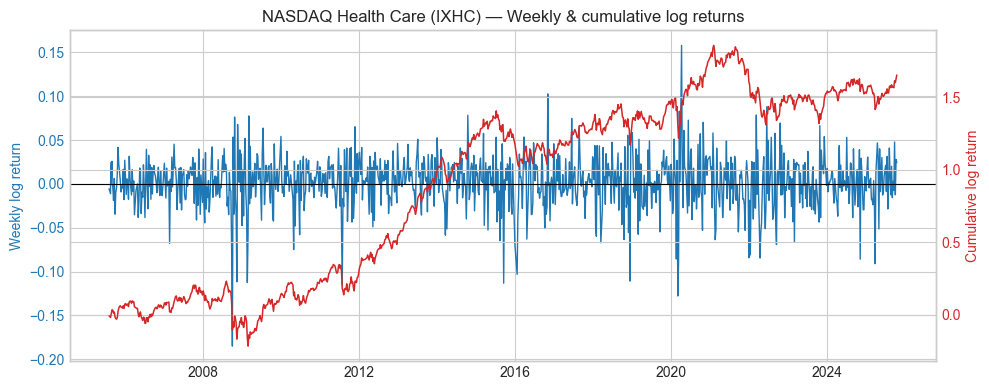

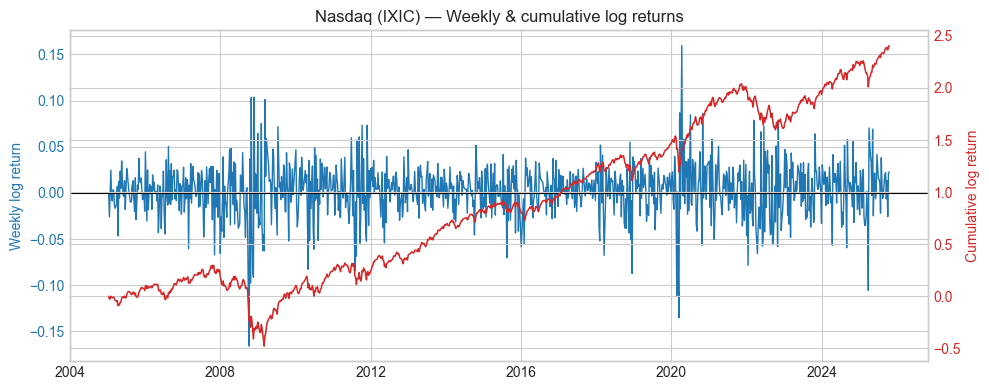

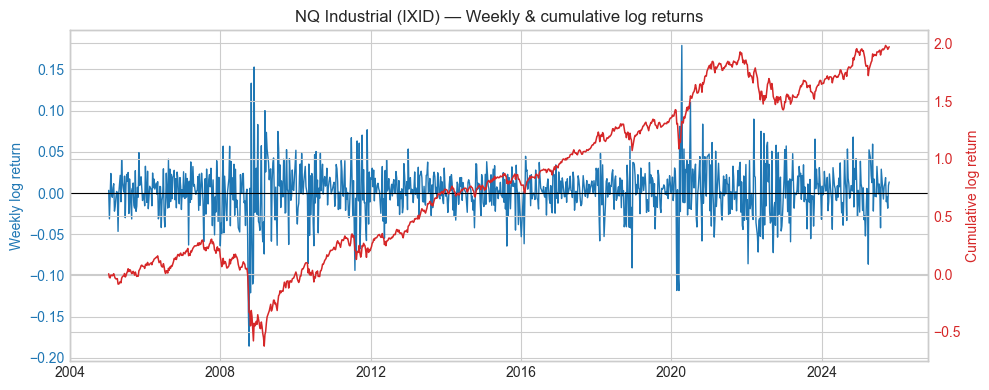

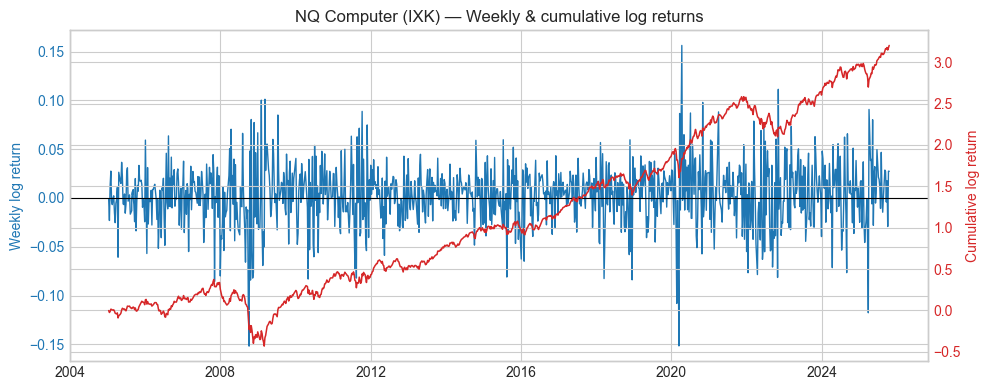

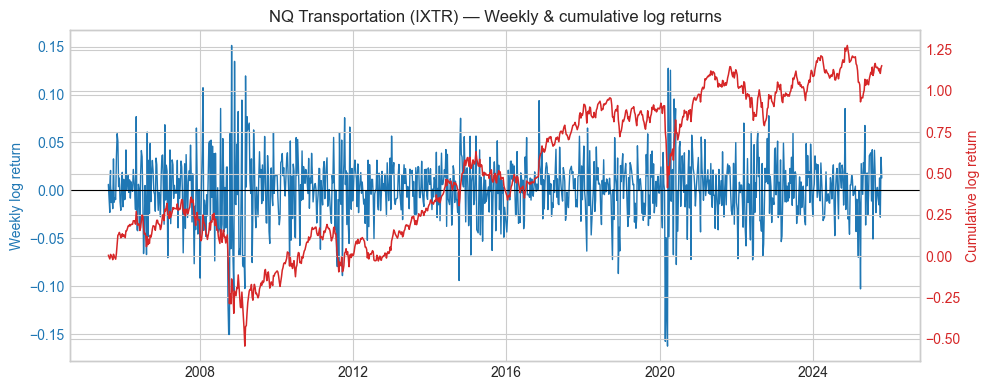

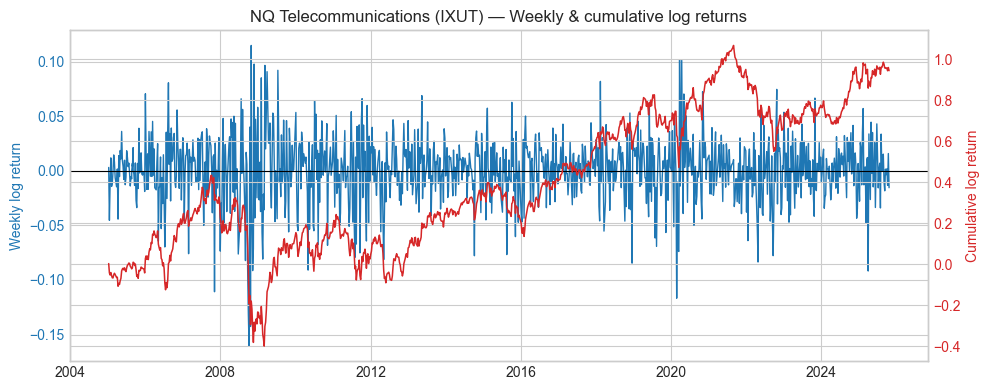

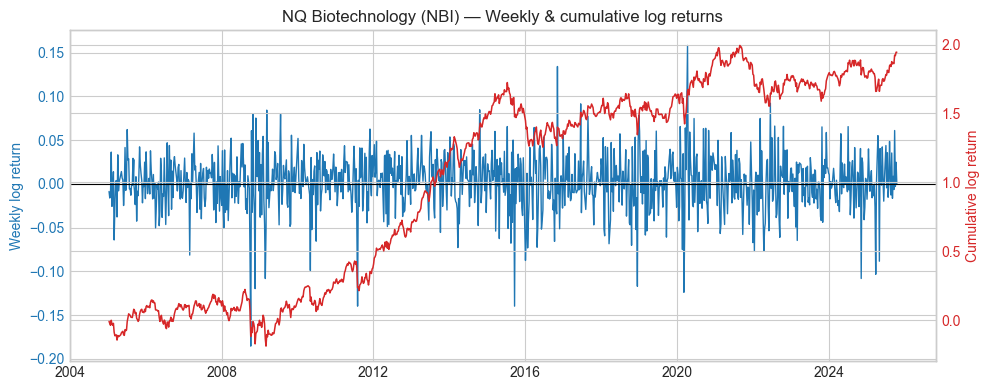

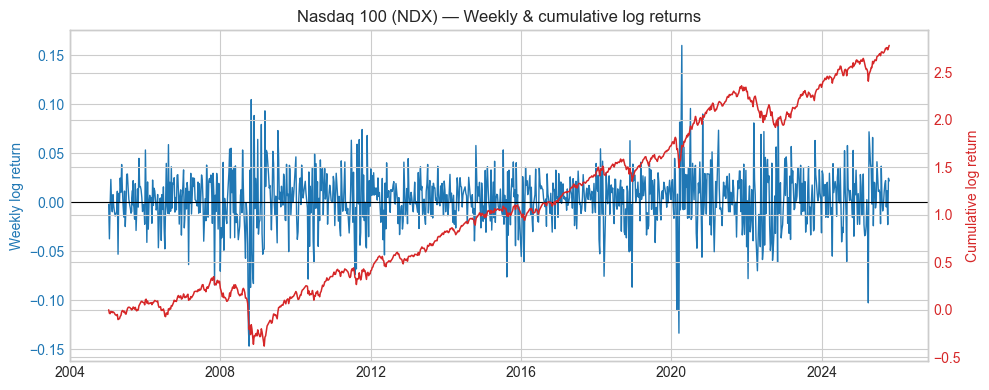

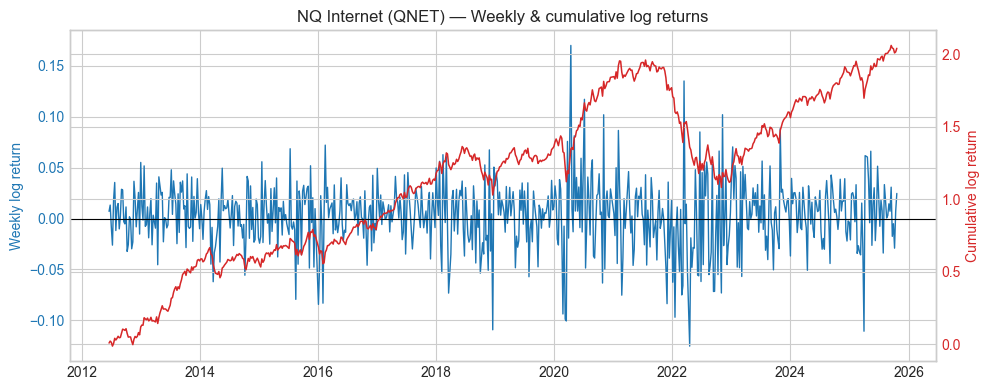

In [54]:
# ============================================================
# 6) Plot weekly & cumulative log returns for selected US indices
# ============================================================
plt.style.use("seaborn-v0_8-whitegrid")

# Map index names → codes based on friday_df
index_map = (
    friday_df[friday_df["IndexName"].isin(index_names)]
    .groupby("IndexName")["Indexcd"]
    .unique()
    .reset_index()
)

# Convert array of codes into a flat list
plot_codes = sorted(list({code for codes in index_map["Indexcd"] for code in codes}))

for code in plot_codes:
    sub = us_weekly[us_weekly["Indexcd"] == code].dropna(subset=["LogReturn"])
    if sub.empty:
        continue
    name = sub["IndexName"].iloc[0]

    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.plot(sub["WeekStart"], sub["LogReturn"], linewidth=1.0, color="tab:blue", label="Weekly log return")
    ax1.axhline(0, color="black", linewidth=0.8)
    ax1.set_ylabel("Weekly log return", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.plot(sub["WeekStart"], sub["CumLogReturn"], linewidth=1.1, color="tab:red", label="Cumulative log return")
    ax2.set_ylabel("Cumulative log return", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    plt.title(f"{name} ({code}) — Weekly & cumulative log returns")
    plt.xlabel("Week")
    plt.tight_layout()
    plt.show()


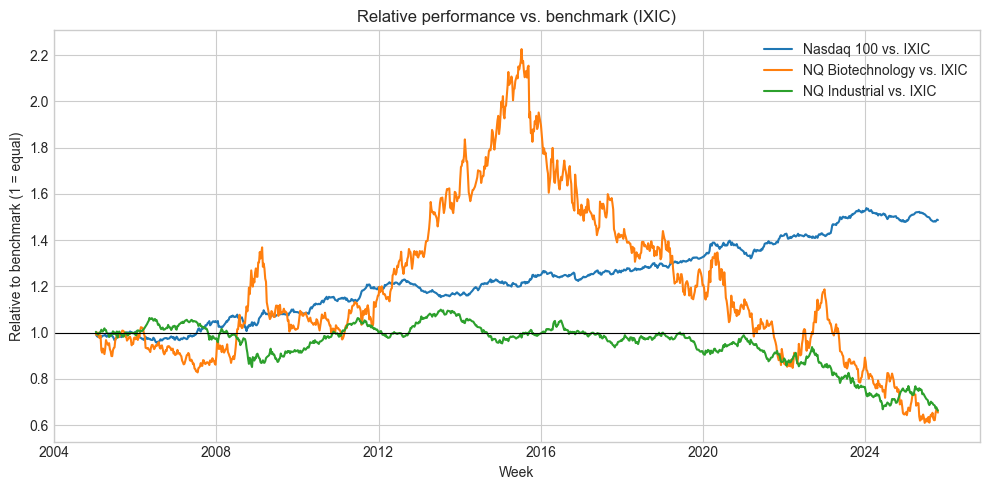

In [44]:
# ============================================================
# Relative performance vs. a US benchmark (Nasdaq Composite / IXIC)
# ============================================================
# Example 1: Nasdaq-related
codes = ["IXIC", "NDX", "NBI", "IXID"]
benchmark = "IXIC"

df = friday_df[friday_df["Indexcd"].isin(codes)].copy()
df["Clsidx"] = pd.to_numeric(df["Clsidx"], errors="coerce")
df.loc[df["Clsidx"] <= 0, "Clsidx"] = np.nan

if "Year" not in df.columns or "Week" not in df.columns:
    df[["Year", "Week"]] = df["Date"].astype(str).str.split("-", expand=True).astype(int)

df["WeekStart"] = df.apply(lambda r: pd.Timestamp.fromisocalendar(int(r["Year"]), int(r["Week"]), 1), axis=1)
df = df.sort_values(["Indexcd", "WeekStart"])

df["LogReturn"] = np.log(df["Clsidx"]).groupby(df["Indexcd"]).diff()

pivot = (
    df.groupby(["Indexcd", "WeekStart"])["LogReturn"]
      .mean()
      .unstack("Indexcd")
      .sort_index()
)

pivot = pivot.dropna(subset=[benchmark])

rel = {}
names = {}
for code in codes:
    if code == benchmark or code not in pivot.columns:
        continue
    pair = pivot[[benchmark, code]].dropna()
    if pair.empty:
        continue
    ex_ret = (pair[code] - pair[benchmark]).cumsum()
    rel[code] = np.exp(ex_ret)  # start at 1
    nm = df.loc[df["Indexcd"] == code, "IndexName"]
    names[code] = nm.dropna().iloc[0] if not nm.dropna().empty else code

plt.figure(figsize=(10, 5))
for code, series in rel.items():
    plt.plot(series.index, series.values, label=f"{names[code]} vs. {benchmark}")
plt.axhline(1.0, color="black", linewidth=0.8)
plt.title(f"Relative performance vs. benchmark ({benchmark})")
plt.ylabel("Relative to benchmark (1 = equal)")
plt.xlabel("Week")
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
# ============================================================
# Export US indices (IXIC, NDX, …) as “real-date” CSVs (Friday)
# ============================================================
def iso_yearweek_to_friday(y: int, w: int) -> pd.Timestamp:
    """Convert ISO year/week to actual Friday date."""
    return pd.Timestamp.fromisocalendar(int(y), int(w), 5)

export_us_codes = ["IXIC", "NDX", "IXHC", "IXID", "NBI"]

for code in export_us_codes:
    sub = friday_df.loc[friday_df["Indexcd"] == code, ["Date", "Clsidx"]].dropna().copy()
    sub[["Year", "Week"]] = sub["Date"].astype(str).str.split("-", expand=True).astype(int)
    sub["Date"] = sub.apply(lambda r: iso_yearweek_to_friday(r["Year"], r["Week"]), axis=1)
    sub = sub[["Date", "Clsidx"]].rename(columns={"Clsidx": "Close"}).sort_values("Date").drop_duplicates("Date")
    out_name = f"{code}_index.csv"
    sub.to_csv(out_name, index=False)
    print(f"✅ {out_name} saved: {len(sub)} rows")

print("All selected US subindices exported.")

✅ IXIC_index.csv saved: 1047 rows
✅ NDX_index.csv saved: 1047 rows
✅ IXHC_index.csv saved: 1016 rows
✅ IXID_index.csv saved: 1045 rows
✅ NBI_index.csv saved: 1048 rows
All selected US subindices exported.


In [105]:
for name in index_names:
    # Nach Index filtern
    subset = friday_df[friday_df['IndexName'] == name].copy()
    
    if subset.empty:
        print(f"\n⚠️ {name}: Keine Einträge gefunden.")
        continue

    # Spalte 'Date' im Format YYYY-WW -> in zwei Spalten Jahr und Woche zerlegen
    subset[['Year', 'Week']] = subset['Date'].astype(str).str.split('-', expand=True)
    subset['Year'] = subset['Year'].astype(int)
    subset['Week'] = subset['Week'].astype(int)
    
    # Nach Jahr und Woche sortieren
    subset = subset.sort_values(['Year', 'Week']).reset_index(drop=True)
    
    # Erstes und letztes Label (YYYY-WW)
    first_date = subset['Date'].iloc[0]
    last_date  = subset['Date'].iloc[-1]
    
    print(f"\n📊 {name}")
    print(f"   Erstes Date-Label (YYYY-WW): {first_date}")
    print(f"   Letztes Date-Label (YYYY-WW): {last_date}")
    print(f"   Zeilen insgesamt: {len(subset)}")
    
    # Vorschau
    display(subset.head(3))
    display(subset.tail(3))



📊 Nasdaq 100
   Erstes Date-Label (YYYY-WW): 2005-01
   Letztes Date-Label (YYYY-WW): 2025-43
   Zeilen insgesamt: 1047


,Indexcd,IndexName,Date,Clsidx,Year,Week
0,NDX,Nasdaq 100,2005-01,1564.81,2005,1
1,NDX,Nasdaq 100,2005-02,1561.11,2005,2
2,NDX,Nasdaq 100,2005-03,1503.64,2005,3


,Indexcd,IndexName,Date,Clsidx,Year,Week
1044,NDX,Nasdaq 100,2025-41,24221.75,2025,41
1045,NDX,Nasdaq 100,2025-42,24817.95,2025,42
1046,NDX,Nasdaq 100,2025-43,25358.16,2025,43



📊 NQ Telecommunications
   Erstes Date-Label (YYYY-WW): 2005-01
   Letztes Date-Label (YYYY-WW): 2025-43
   Zeilen insgesamt: 1048


,Indexcd,IndexName,Date,Clsidx,Year,Week
0,IXUT,NQ Telecommunications,2005-01,191.90,2005,1
1,IXUT,NQ Telecommunications,2005-02,192.50,2005,2
2,IXUT,NQ Telecommunications,2005-03,183.97,2005,3


,Indexcd,IndexName,Date,Clsidx,Year,Week
1045,IXUT,NQ Telecommunications,2025-41,493.66,2025,41
1046,IXUT,NQ Telecommunications,2025-42,501.56,2025,42
1047,IXUT,NQ Telecommunications,2025-43,493.88,2025,43



📊 NASDAQ Health Care
   Erstes Date-Label (YYYY-WW): 2005-31
   Letztes Date-Label (YYYY-WW): 2025-43
   Zeilen insgesamt: 1016


,Indexcd,IndexName,Date,Clsidx,Year,Week
0,IXHC,NASDAQ Health Care,2005-31,211.45,2005,31
1,IXHC,NASDAQ Health Care,2005-32,210.28,2005,32
2,IXHC,NASDAQ Health Care,2005-34,207.93,2005,34


,Indexcd,IndexName,Date,Clsidx,Year,Week
1013,IXHC,NASDAQ Health Care,2025-41,1046.95,2025,41
1014,IXHC,NASDAQ Health Care,2025-42,1076.56,2025,42
1015,IXHC,NASDAQ Health Care,2025-43,1103.09,2025,43



📊 NQ Transportation
   Erstes Date-Label (YYYY-WW): 2005-31
   Letztes Date-Label (YYYY-WW): 2025-43
   Zeilen insgesamt: 1018


,Indexcd,IndexName,Date,Clsidx,Year,Week
0,IXTR,NQ Transportation,2005-31,2165.39,2005,31
1,IXTR,NQ Transportation,2005-32,2178.94,2005,32
2,IXTR,NQ Transportation,2005-34,2129.50,2005,34


,Indexcd,IndexName,Date,Clsidx,Year,Week
1015,IXTR,NQ Transportation,2025-41,6545.3,2025,41
1016,IXTR,NQ Transportation,2025-42,6775.2,2025,42
1017,IXTR,NQ Transportation,2025-43,6863.8,2025,43



📊 DJ Composite
   Erstes Date-Label (YYYY-WW): 2005-01
   Letztes Date-Label (YYYY-WW): 2025-43
   Zeilen insgesamt: 1010


,Indexcd,IndexName,Date,Clsidx,Year,Week
0,DJC,DJ Composite,2005-01,3304.14,2005,1
1,DJC,DJ Composite,2005-02,3293.06,2005,2
2,DJC,DJ Composite,2005-03,3239.05,2005,3


,Indexcd,IndexName,Date,Clsidx,Year,Week
1007,DJC,DJ Composite,2025-41,14092.0,2025,41
1008,DJC,DJ Composite,2025-42,14376.3,2025,42
1009,DJC,DJ Composite,2025-43,14531.3,2025,43



📊 DJ Transportation
   Erstes Date-Label (YYYY-WW): 2005-01
   Letztes Date-Label (YYYY-WW): 2025-43
   Zeilen insgesamt: 1010


,Indexcd,IndexName,Date,Clsidx,Year,Week
0,DJT,DJ Transportation,2005-01,3636.78,2005,1
1,DJT,DJ Transportation,2005-02,3534.15,2005,2
2,DJT,DJ Transportation,2005-03,3471.17,2005,3


,Indexcd,IndexName,Date,Clsidx,Year,Week
1007,DJT,DJ Transportation,2025-41,15067.9,2025,41
1008,DJT,DJ Transportation,2025-42,15676.3,2025,42
1009,DJT,DJ Transportation,2025-43,15454.7,2025,43



📊 DJ Health Care
   Erstes Date-Label (YYYY-WW): 2005-33
   Letztes Date-Label (YYYY-WW): 2025-43
   Zeilen insgesamt: 980


,Indexcd,IndexName,Date,Clsidx,Year,Week
0,DJUSHC,DJ Health Care,2005-33,311.00,2005,33
1,DJUSHC,DJ Health Care,2005-34,307.63,2005,34
2,DJUSHC,DJ Health Care,2005-35,313.77,2005,35


,Indexcd,IndexName,Date,Clsidx,Year,Week
977,DJUSHC,DJ Health Care,2025-41,1515.88,2025,41
978,DJUSHC,DJ Health Care,2025-42,1529.30,2025,42
979,DJUSHC,DJ Health Care,2025-43,1557.62,2025,43



📊 DJ Technology
   Erstes Date-Label (YYYY-WW): 2005-33
   Letztes Date-Label (YYYY-WW): 2025-43
   Zeilen insgesamt: 980


,Indexcd,IndexName,Date,Clsidx,Year,Week
0,DJUSTC,DJ Technology,2005-33,493.45,2005,33
1,DJUSTC,DJ Technology,2005-34,491.43,2005,34
2,DJUSTC,DJ Technology,2005-35,495.01,2005,35


,Indexcd,IndexName,Date,Clsidx,Year,Week
977,DJUSTC,DJ Technology,2025-41,8389.5,2025,41
978,DJUSTC,DJ Technology,2025-42,8597.8,2025,42
979,DJUSTC,DJ Technology,2025-43,8833.4,2025,43



📊 NQ Internet
   Erstes Date-Label (YYYY-WW): 2012-24
   Letztes Date-Label (YYYY-WW): 2025-43
   Zeilen insgesamt: 674


,Indexcd,IndexName,Date,Clsidx,Year,Week
0,QNET,NQ Internet,2012-24,221.27,2012,24
1,QNET,NQ Internet,2012-25,222.84,2012,25
2,QNET,NQ Internet,2012-26,225.81,2012,26


,Indexcd,IndexName,Date,Clsidx,Year,Week
671,QNET,NQ Internet,2025-41,1650.75,2025,41
672,QNET,NQ Internet,2025-42,1662.73,2025,42
673,QNET,NQ Internet,2025-43,1704.24,2025,43



📊 Nasdaq
   Erstes Date-Label (YYYY-WW): 2005-01
   Letztes Date-Label (YYYY-WW): 2025-43
   Zeilen insgesamt: 1047


,Indexcd,IndexName,Date,Clsidx,Year,Week
0,IXIC,Nasdaq,2005-01,2088.61,2005,1
1,IXIC,Nasdaq,2005-02,2087.91,2005,2
2,IXIC,Nasdaq,2005-03,2034.27,2005,3


,Indexcd,IndexName,Date,Clsidx,Year,Week
1044,IXIC,Nasdaq,2025-41,22204.43,2025,41
1045,IXIC,Nasdaq,2025-42,22679.97,2025,42
1046,IXIC,Nasdaq,2025-43,23204.87,2025,43



📊 NQ Industrial
   Erstes Date-Label (YYYY-WW): 2005-01
   Letztes Date-Label (YYYY-WW): 2025-43
   Zeilen insgesamt: 1045


,Indexcd,IndexName,Date,Clsidx,Year,Week
0,IXID,NQ Industrial,2005-01,1769.25,2005,1
1,IXID,NQ Industrial,2005-02,1774.98,2005,2
2,IXID,NQ Industrial,2005-03,1720.22,2005,3


,Indexcd,IndexName,Date,Clsidx,Year,Week
1042,IXID,NQ Industrial,2025-41,12415.64,2025,41
1043,IXID,NQ Industrial,2025-42,12529.51,2025,42
1044,IXID,NQ Industrial,2025-43,12698.50,2025,43



📊 NQ Computer
   Erstes Date-Label (YYYY-WW): 2005-01
   Letztes Date-Label (YYYY-WW): 2025-43
   Zeilen insgesamt: 1046


,Indexcd,IndexName,Date,Clsidx,Year,Week
0,IXK,NQ Computer,2005-01,924.84,2005,1
1,IXK,NQ Computer,2005-02,923.86,2005,2
2,IXK,NQ Computer,2005-03,902.74,2005,3


,Indexcd,IndexName,Date,Clsidx,Year,Week
1043,IXK,NQ Computer,2025-41,21540.8,2025,41
1044,IXK,NQ Computer,2025-42,22139.2,2025,42
1045,IXK,NQ Computer,2025-43,22752.4,2025,43



📊 NQ Biotechnology
   Erstes Date-Label (YYYY-WW): 2005-01
   Letztes Date-Label (YYYY-WW): 2025-43
   Zeilen insgesamt: 1048


,Indexcd,IndexName,Date,Clsidx,Year,Week
0,NBI,NQ Biotechnology,2005-01,742.54,2005,1
1,NBI,NQ Biotechnology,2005-02,736.12,2005,2
2,NBI,NQ Biotechnology,2005-03,724.34,2005,3


,Indexcd,IndexName,Date,Clsidx,Year,Week
1045,NBI,NQ Biotechnology,2025-41,5061.5,2025,41
1046,NBI,NQ Biotechnology,2025-42,5188.0,2025,42
1047,NBI,NQ Biotechnology,2025-43,5188.6,2025,43


In [12]:
import pandas as pd
from datetime import date

# --- Hilfsfunktionen ---
def weeks_in_year(y: int) -> int:
    # ISO-Kalender: 52 oder 53 Wochen
    return pd.Timestamp(f"{y}-12-31").isocalendar()[1]

def ensure_yyyy_ww(df: pd.DataFrame) -> pd.DataFrame:
    """Erzeugt Spalte 'Date' als YYYY-WW, falls nur Trddt vorhanden ist."""
    out = df.copy()
    if 'Date' not in out.columns:
        out['Trddt'] = pd.to_datetime(out['Trddt'], errors='coerce')
        iso = out['Trddt'].dt.isocalendar()
        out['Year'] = iso['year'].astype(int)
        out['Week'] = iso['week'].astype(int)
        out['Date'] = out['Year'].astype(str) + "-" + out['Week'].astype(str).str.zfill(2)
    else:
        # Falls Date schon da ist, Year/Week sauber ableiten (für Sortierung)
        out[['Year','Week']] = out['Date'].astype(str).str.split('-', expand=True)
        out['Year'] = out['Year'].astype(int)
        out['Week'] = out['Week'].astype(int)
    return out

def compress_missing(yw_list):
    """Fasst fehlende YYYY-WW in zusammenhängende Spannen zusammen."""
    spans = []
    if not yw_list:
        return spans
    # in (year, week) Tupel umwandeln und sortieren
    tups = [tuple(map(int, x.split('-'))) for x in yw_list]
    tups.sort()
    start = prev_y, prev_w = tups[0]
    for y, w in tups[1:]:
        # prüfen, ob (y,w) direkt auf (prev_y,prev_w) folgt
        next_y, next_w = prev_y, prev_w + 1
        if next_w > weeks_in_year(prev_y):
            next_y, next_w = prev_y + 1, 1
        if (y, w) == (next_y, next_w):
            prev_y, prev_w = y, w
        else:
            spans.append({
                'from': f"{start[0]}-{str(start[1]).zfill(2)}",
                'to':   f"{prev_y}-{str(prev_w).zfill(2)}",
            })
            start = prev_y, prev_w = (y, w)
    spans.append({
        'from': f"{start[0]}-{str(start[1]).zfill(2)}",
        'to':   f"{prev_y}-{str(prev_w).zfill(2)}",
    })
    return spans

# --- Hauptlogik: fehlende Wochen je Index ---
summary_rows = []
gap_details = {}

for name in index_names:
    sub = friday_df[friday_df['IndexName'] == name].copy()
    sub = ensure_yyyy_ww(sub)

    if sub.empty:
        summary_rows.append({
            'IndexName': name,
            'first_yyyyww': None,
            'last_yyyyww': None,
            'observed_weeks': 0,
            'expected_weeks': 0,
            'missing_weeks': 0,
            'num_gaps': 0
        })
        gap_details[name] = []
        print(f"\n⚠️ {name}: Keine Einträge gefunden.")
        continue

    # Zeitraum bestimmen
    min_year, max_year = sub['Year'].min(), sub['Year'].max()

    # Erwartete YYYY-WW-Liste über den ganzen Zeitraum
    expected = []
    for y in range(min_year, max_year + 1):
        expected += [f"{y}-{str(w).zfill(2)}" for w in range(1, weeks_in_year(y) + 1)]

    observed = sorted(set(sub['Date'].astype(str)))
    missing = sorted(set(expected) - set(observed))

    # Spannen der fehlenden Wochen bilden
    spans = compress_missing(missing)
    gap_details[name] = spans

    first_yyyyww = observed[0] if observed else None
    last_yyyyww  = observed[-1] if observed else None

    summary_rows.append({
        'IndexName': name,
        'first_yyyyww': first_yyyyww,
        'last_yyyyww': last_yyyyww,
        'observed_weeks': len(observed),
        'expected_weeks': len(expected),
        'missing_weeks': len(missing),
        'num_gaps': len(spans)
    })

    # Ausgabe
    print(f"\n📊 {name}")
    print(f"   Erstes YYYY-WW: {first_yyyyww}")
    print(f"   Letztes YYYY-WW: {last_yyyyww}")
    print(f"   Beobachtete Wochen: {len(observed)} | Erwartet: {len(expected)} | Fehlend: {len(missing)}")
    if spans:
        print("   Lücken (zusammenhängende Wochen):")
        for s in spans[:10]:
            print(f"     • {s['from']} → {s['to']}")
        if len(spans) > 10:
            print(f"     … {len(spans)-10} weitere Spannen")
    else:
        print("   ✅ Keine fehlenden Wochen im betrachteten Zeitraum.")

# Zusammenfassungstabelle
summary_df = pd.DataFrame(summary_rows).sort_values('IndexName').reset_index(drop=True)
display(summary_df)



📊 Nasdaq 100
   Erstes YYYY-WW: 2005-01
   Letztes YYYY-WW: 2025-43
   Beobachtete Wochen: 1047 | Erwartet: 636 | Fehlend: 27
   Lücken (zusammenhängende Wochen):
     • 2005-12 → 2005-12
     • 2006-15 → 2006-15
     • 2009-15 → 2009-15
     • 2009-27 → 2009-27
     • 2009-52 → 2009-53
     • 2010-13 → 2010-13
     • 2010-16 → 2010-16
     • 2010-51 → 2010-51
     • 2011-16 → 2011-16
     • 2015-14 → 2015-14
     … 13 weitere Spannen

📊 NQ Telecommunications
   Erstes YYYY-WW: 2005-01
   Letztes YYYY-WW: 2025-43
   Beobachtete Wochen: 1048 | Erwartet: 636 | Fehlend: 26
   Lücken (zusammenhängende Wochen):
     • 2005-12 → 2005-12
     • 2006-15 → 2006-15
     • 2009-15 → 2009-15
     • 2009-27 → 2009-27
     • 2009-52 → 2009-53
     • 2010-13 → 2010-13
     • 2010-16 → 2010-16
     • 2010-51 → 2010-51
     • 2011-16 → 2011-16
     • 2015-14 → 2015-14
     … 12 weitere Spannen

📊 NASDAQ Health Care
   Erstes YYYY-WW: 2005-31
   Letztes YYYY-WW: 2025-43
   Beobachtete Wochen: 1016 | Er

,IndexName,first_yyyyww,last_yyyyww,observed_weeks,expected_weeks,missing_weeks,num_gaps
0,DJ Composite,2005-01,2025-43,1010,636,33,22
1,DJ Health Care,2005-33,2025-43,980,636,63,21
2,DJ Technology,2005-33,2025-43,980,636,63,21
3,DJ Transportation,2005-01,2025-43,1010,636,34,23
4,NASDAQ Health Care,2005-31,2025-43,1016,636,58,24
5,NQ Computer,2005-01,2025-43,1046,636,28,24
6,NQ Industrial,2005-01,2025-43,1045,636,29,24
7,NQ Internet,2012-24,2025-43,674,373,17,14
8,NQ Telecommunications,2005-01,2025-43,1048,636,26,22
9,NQ Transportation,2005-31,2025-43,1018,636,56,23


In [13]:
nasdaq100_df.head()


,Indexcd,IndexName,Date,Clsidx
85,IXIC,Nasdaq,2005-01,2088.61
253,IXIC,Nasdaq,2005-02,2087.91
427,IXIC,Nasdaq,2005-03,2034.27
647,IXIC,Nasdaq,2005-04,2035.83
794,IXIC,Nasdaq,2005-05,2086.66


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


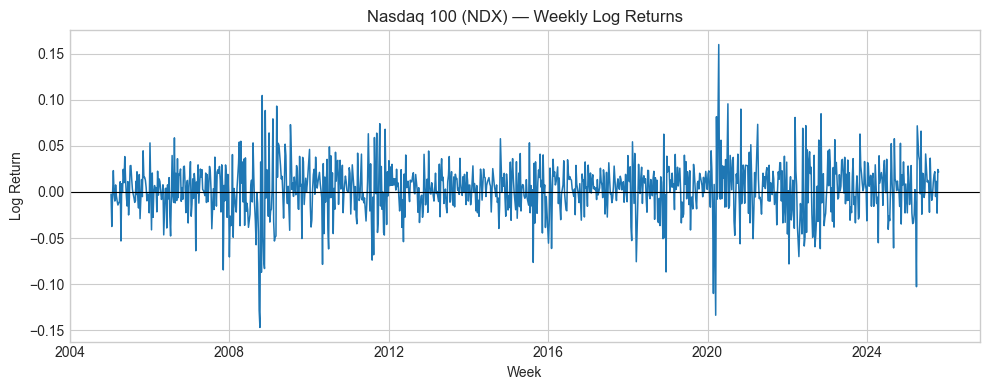

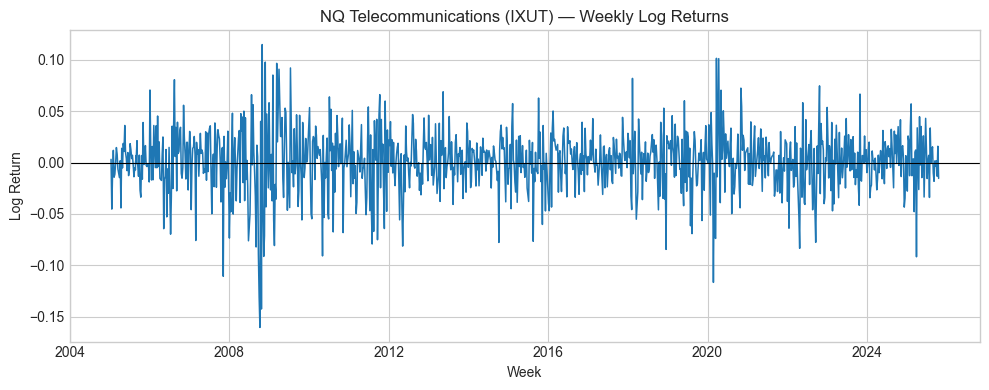

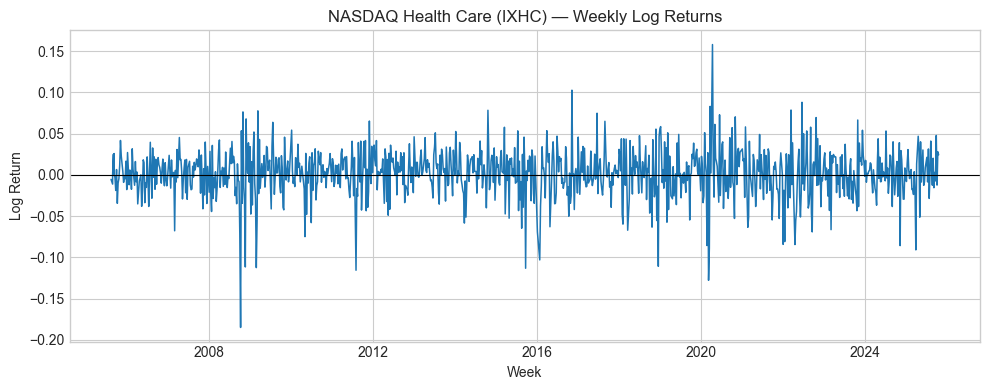

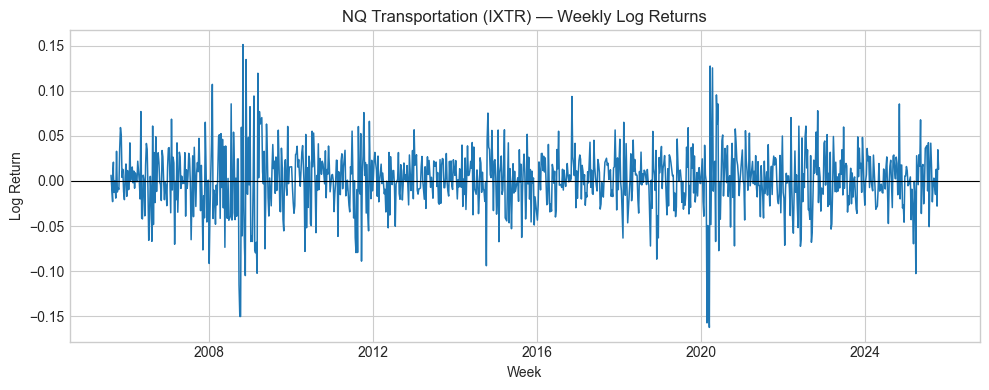

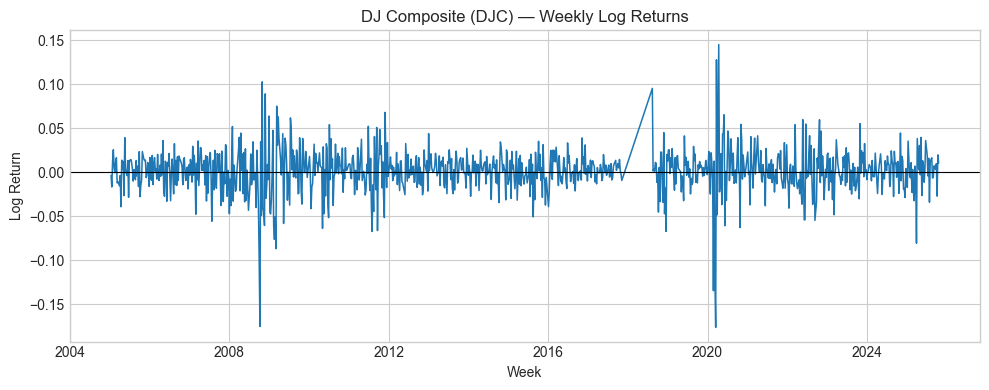

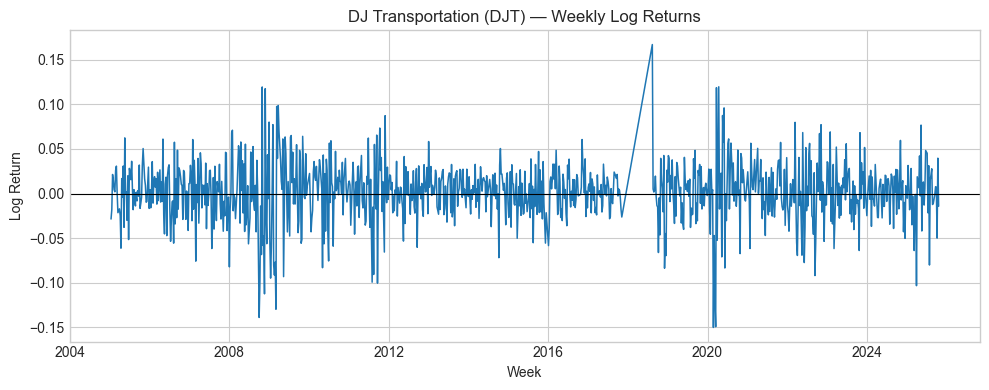

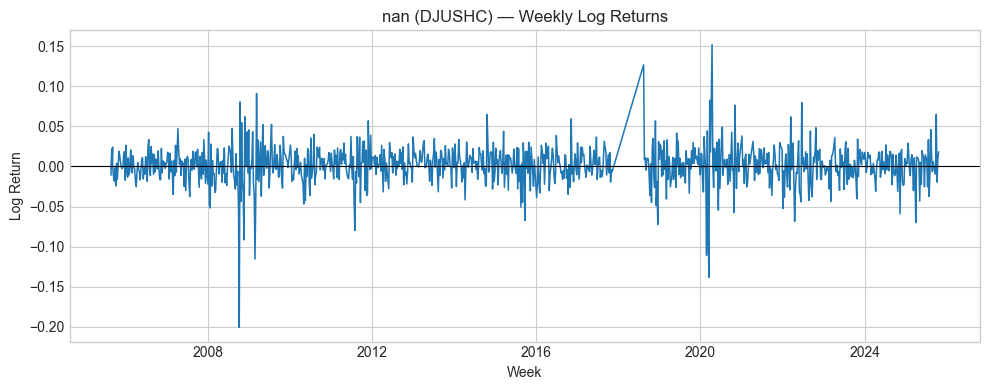

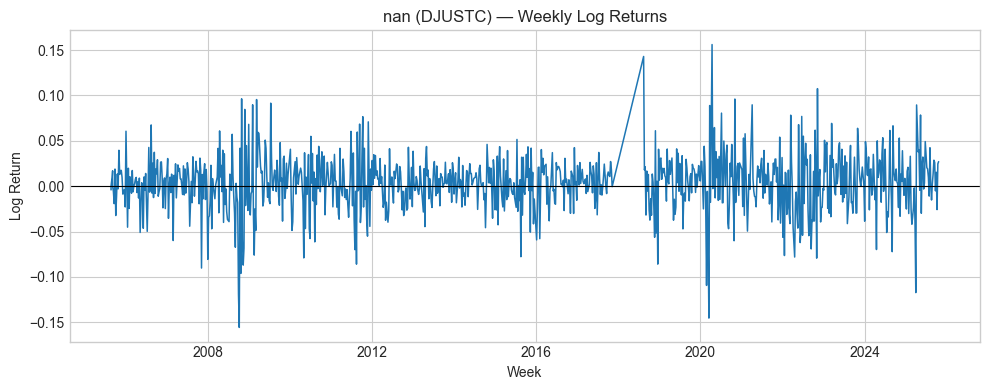

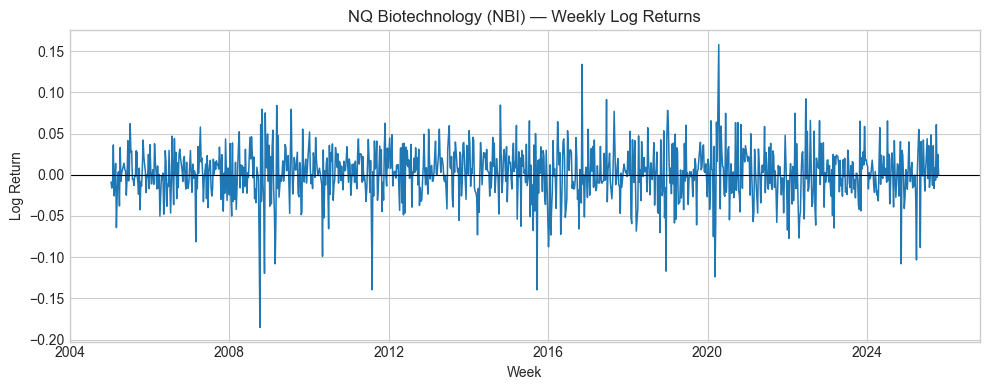

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === deine Weekly-Tabelle ===
# z.B.: us_weekly = friday_df[['Indexcd','IndexName','Date','Clsidx']].copy()
us_weekly = friday_df[['Indexcd','IndexName','Date','Clsidx']].copy()

# YYYY-WW -> Jahr/Woche -> Wochenstart (Montag)
us_weekly[['Year','Week']] = us_weekly['Date'].astype(str).str.split('-', expand=True).astype(int)
us_weekly['WeekStart'] = us_weekly.apply(
    lambda r: pd.Timestamp.fromisocalendar(int(r['Year']), int(r['Week']), 1), axis=1
)

# sortieren & Log-Returns je Index
us_weekly = us_weekly.sort_values(['Indexcd','Year','Week'])
us_weekly['Clsidx'] = pd.to_numeric(us_weekly['Clsidx'], errors='coerce')
us_weekly['LogReturn'] = np.log(us_weekly['Clsidx']).groupby(us_weekly['Indexcd']).diff()

# ===== Plot der wöchentlichen Log-Returns pro ausgewähltem Index =====
codes = ['NDX','IXUT','IXHC','IXTR','DJC','DJT','DJUSHC','DJUSTC', 'NBI']   # anpassen
plt.style.use('seaborn-v0_8-whitegrid')
for code in codes:
    sub = us_weekly[us_weekly['Indexcd'] == code].dropna(subset=['LogReturn'])
    if sub.empty: 
        continue
    name = sub['IndexName'].iloc[0]
    plt.figure(figsize=(10,4))
    plt.plot(sub['WeekStart'], sub['LogReturn'], linewidth=1.1)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title(f"{name} ({code}) — Weekly Log Returns")
    plt.xlabel("Week"); plt.ylabel("Log Return")
    plt.tight_layout(); plt.show()



/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


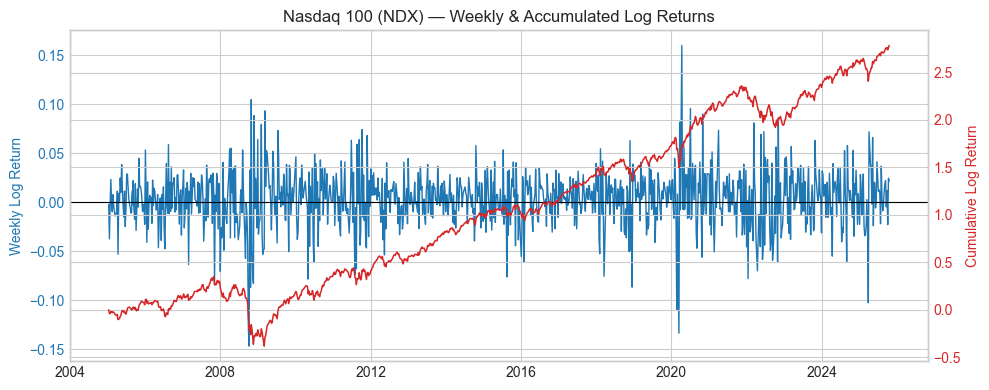

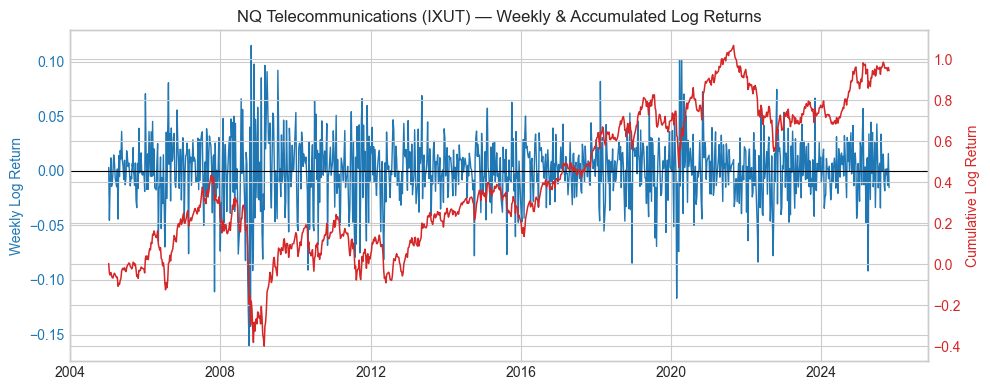

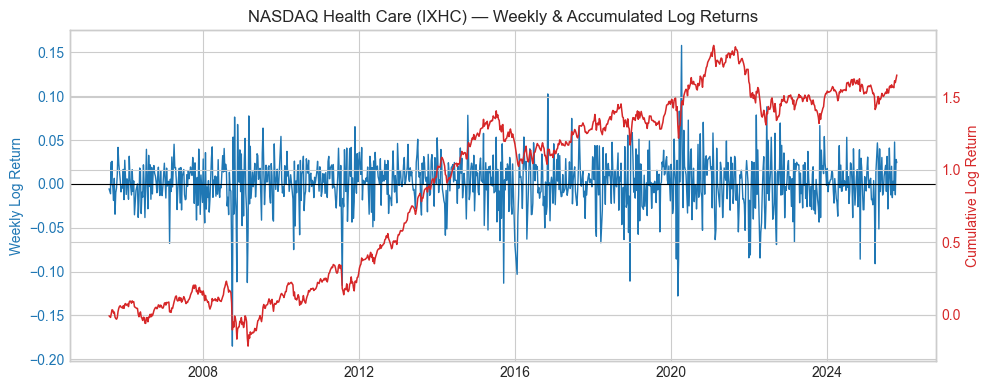

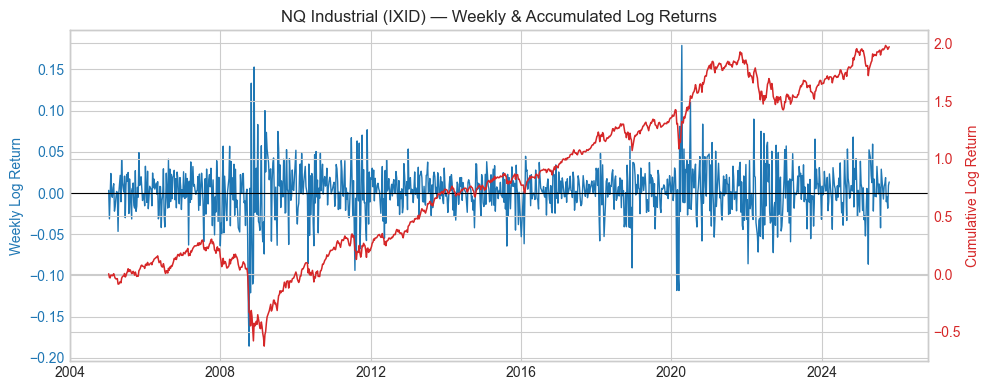

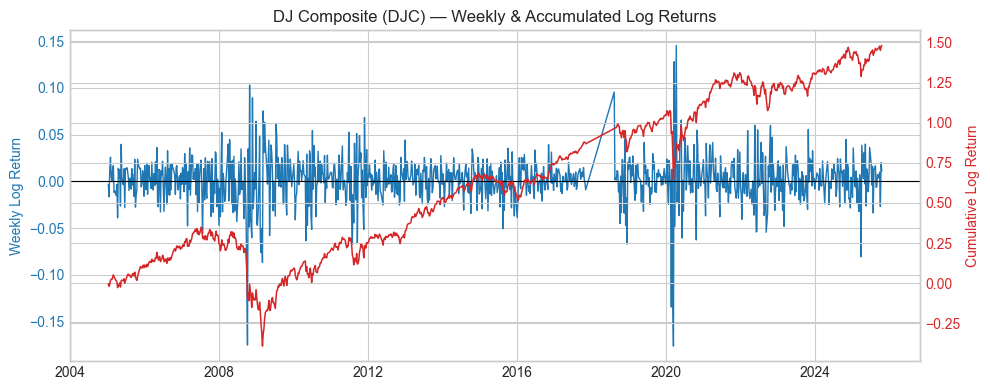

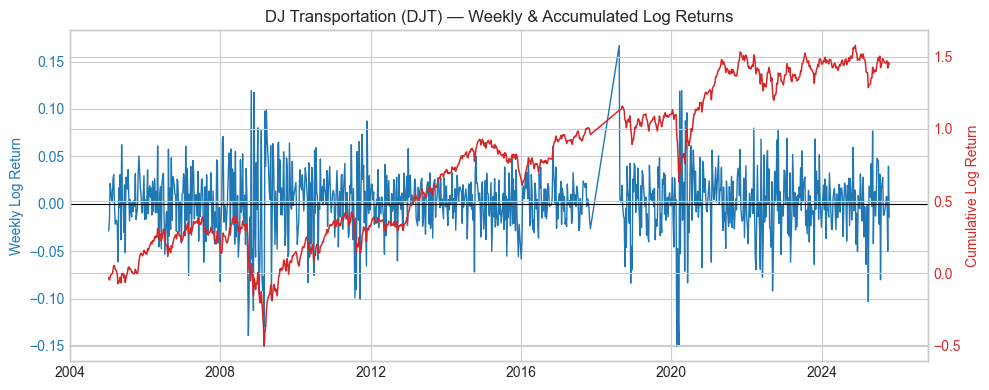

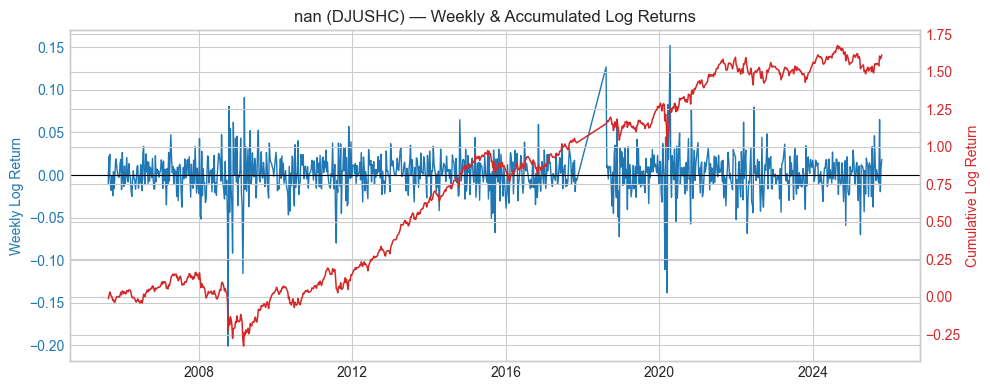

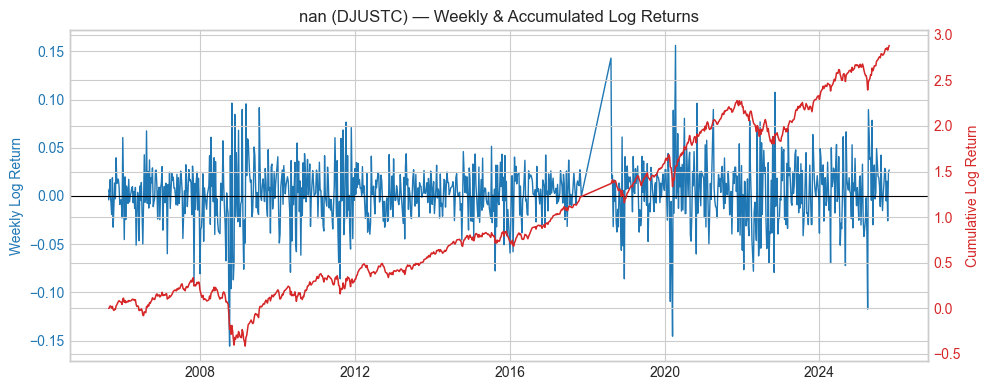

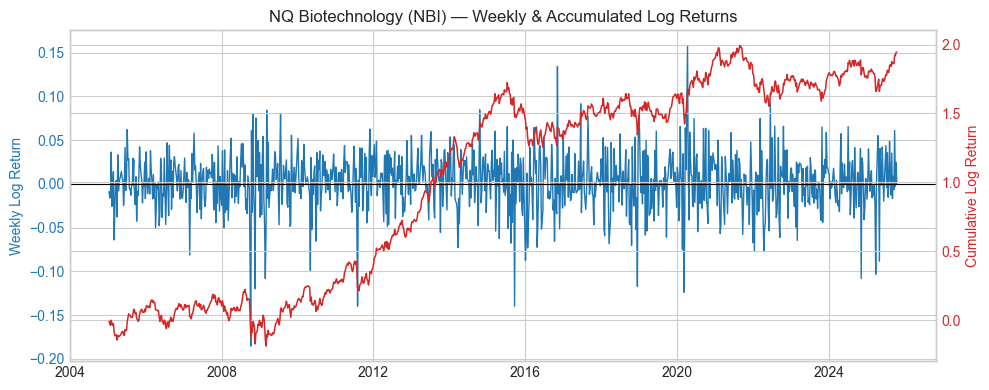

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Deine Weekly-Tabelle ===
us_weekly = friday_df[['Indexcd','IndexName','Date','Clsidx']].copy()

# YYYY-WW -> Jahr/Woche -> Wochenstart (Montag)
us_weekly[['Year','Week']] = us_weekly['Date'].astype(str).str.split('-', expand=True).astype(int)
us_weekly['WeekStart'] = us_weekly.apply(
    lambda r: pd.Timestamp.fromisocalendar(int(r['Year']), int(r['Week']), 1), axis=1
)

# sortieren & Log-Returns je Index
us_weekly = us_weekly.sort_values(['Indexcd','Year','Week'])
us_weekly['Clsidx'] = pd.to_numeric(us_weekly['Clsidx'], errors='coerce')

# Logarithmische Wochenrenditen
us_weekly['LogReturn'] = np.log(us_weekly['Clsidx']).groupby(us_weekly['Indexcd']).diff()

# Kumulative (aufsummierte) Log-Returns pro Index
us_weekly['CumLogReturn'] = us_weekly.groupby('Indexcd')['LogReturn'].cumsum()

# === Plot: Weekly & Accumulated Log Returns ===
codes = ['NDX','IXUT','IXHC','IXID','DJC','DJT','DJUSHC','DJUSTC', 'NBI']   # anpassen

plt.style.use('seaborn-v0_8-whitegrid')

for code in codes:
    sub = us_weekly[us_weekly['Indexcd'] == code].dropna(subset=['LogReturn'])
    if sub.empty: 
        continue
    name = sub['IndexName'].iloc[0]

    fig, ax1 = plt.subplots(figsize=(10,4))

    # Linke Achse: Weekly Log Returns
    ax1.plot(sub['WeekStart'], sub['LogReturn'], color='tab:blue', linewidth=1.0, label='Weekly Log Return')
    ax1.axhline(0, color='black', linewidth=0.8)
    ax1.set_ylabel("Weekly Log Return", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Rechte Achse: Cumulative Log Returns
    ax2 = ax1.twinx()
    ax2.plot(sub['WeekStart'], sub['CumLogReturn'], color='tab:red', linewidth=1.1, label='Cumulative Log Return')
    ax2.set_ylabel("Cumulative Log Return", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title(f"{name} ({code}) — Weekly & Accumulated Log Returns")
    plt.xlabel("Week")
    plt.tight_layout()
    plt.show()


In [16]:
import pandas as pd

# DJUSTC isolieren
sub = friday_df[friday_df['Indexcd'] == 'DJUSTC'].copy()
sub['Trddt'] = pd.to_datetime(sub['Date'], errors='coerce')
sub = sub.sort_values('Trddt').reset_index(drop=True)

# Gap-Infos berechnen
sub['prev_date'] = sub['Trddt'].shift(1)
sub['gap_days']  = (sub['Trddt'] - sub['prev_date']).dt.days
sub['missing_weeks_est'] = (sub['gap_days'] // 7) - 1  # grobe Schätzung: wie viele Wochen fehlen zwischen zwei Punkten

# Nur ab 2016 und nur „große“ Lücken anzeigen (z.B. > 10 Tage)
mask = (sub['Trddt'] >= pd.Timestamp('2016-01-01')) & (sub['gap_days'] > 10)
gaps_2016 = sub.loc[mask, ['prev_date','Trddt','gap_days','missing_weeks_est']].rename(
    columns={'prev_date':'from', 'Trddt':'to'}
).reset_index(drop=True)

print("📉 Große Zeitlücken (>10 Tage) für DJUSTC ab 2016:")
display(gaps_2016.head(20))
print(f"Gefundene Lücken: {len(gaps_2016)}")



📉 Große Zeitlücken (>10 Tage) für DJUSTC ab 2016:


/var/folders/wp/k5t4pl853ng8y6kktqkmy3n80000gn/T/ipykernel_99181/28694551.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sub['Trddt'] = pd.to_datetime(sub['Date'], errors='coerce')


,from,to,gap_days,missing_weeks_est
0,2015-12-01,2016-01-01,31.0,3.0
1,2016-01-01,2016-02-01,31.0,3.0
2,2016-02-01,2016-03-01,29.0,3.0
3,2016-03-01,2016-04-01,31.0,3.0
4,2016-04-01,2016-05-01,30.0,3.0
5,2016-05-01,2016-06-01,31.0,3.0
6,2016-06-01,2016-07-01,30.0,3.0
7,2016-07-01,2016-08-01,31.0,3.0
8,2016-08-01,2016-09-01,31.0,3.0
9,2016-09-01,2016-10-01,30.0,3.0


Gefundene Lücken: 106


In [17]:
us_weekly.head()

,Indexcd,IndexName,Date,Clsidx,Year,Week,WeekStart,LogReturn,CumLogReturn
9245,.DJU,NaN,2005-34,399.90,2005,34,2005-08-22,NaN,NaN
12424,.DJU,NaN,2005-35,416.23,2005,35,2005-08-29,0.040023,0.040023
15674,.DJU,NaN,2005-36,421.05,2005,36,2005-09-05,0.011514,0.051537
7271,A1BSC,NaN,2005-33,190.19,2005,33,2005-08-15,NaN,NaN
8731,A1BSC,NaN,2005-34,186.46,2005,34,2005-08-22,-0.019807,-0.019807


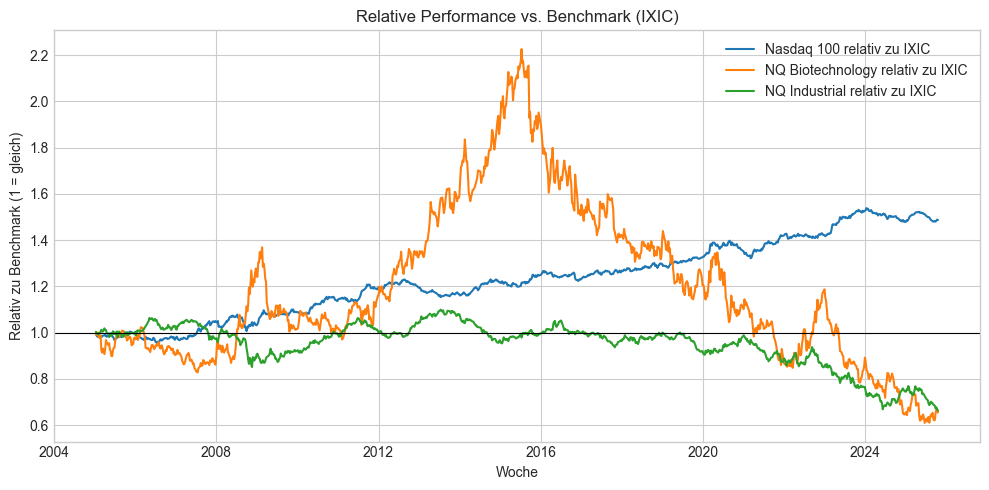

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Dow Jones Indizes ===
codes = ['IXIC', 'NDX', 'NBI', 'IXID']  # Nasdaq 100, Telecommunications, Health Care, Transportation
bench = 'IXIC'

# --- Daten vorbereiten ---
df = friday_df[friday_df['Indexcd'].isin(codes)].copy()
df['Clsidx'] = pd.to_numeric(df['Clsidx'], errors='coerce')
df.loc[df['Clsidx'] <= 0, 'Clsidx'] = np.nan

# Year/Week aus Date (YYYY-WW) ableiten (falls noch nicht vorhanden)
if 'Year' not in df.columns or 'Week' not in df.columns:
    df[['Year','Week']] = df['Date'].astype(str).str.split('-', expand=True).astype(int)

# Wochendatum (Montag jeder ISO-Woche)
df['WeekStart'] = df.apply(lambda r: pd.Timestamp.fromisocalendar(int(r['Year']), int(r['Week']), 1), axis=1)
df = df.sort_values(['Indexcd','WeekStart'])

# --- Wöchentliche Log-Returns ---
df['LogReturn'] = np.log(df['Clsidx']).groupby(df['Indexcd']).diff()

# --- Aggregation, falls es Duplikate je (Indexcd, WeekStart) gibt ---
pivot = (
    df.groupby(['Indexcd','WeekStart'])['LogReturn'].mean()
      .unstack('Indexcd')
      .sort_index()
)

# Nur Wochen behalten, in denen der Benchmark vorhanden ist
pivot = pivot.dropna(subset=[bench])

# --- Relative Performance: exp(cumsum(Subindex - Benchmark)) ---
rel = {}
names = {}
for code in codes:
    if code == bench or code not in pivot.columns:
        continue
    pair = pivot[[bench, code]].dropna()  # gemeinsame Wochen
    if pair.empty:
        continue
    ex_ret = (pair[code] - pair[bench]).cumsum()
    rel[code] = np.exp(ex_ret)            # Start = 1
    nm = df.loc[df['Indexcd']==code, 'IndexName']
    names[code] = (nm.dropna().iloc[0] if not nm.dropna().empty else code)

# --- Plot ---
plt.figure(figsize=(10,5))
for code, series in rel.items():
    plt.plot(series.index, series.values, label=f"{names[code]} relativ zu {bench}")
plt.axhline(1.0, color='black', linewidth=0.8)
plt.title(f"Relative Performance vs. Benchmark ({bench})")
plt.ylabel("Relativ zu Benchmark (1 = gleich)")
plt.xlabel("Woche")
plt.legend()
plt.tight_layout()
plt.show()


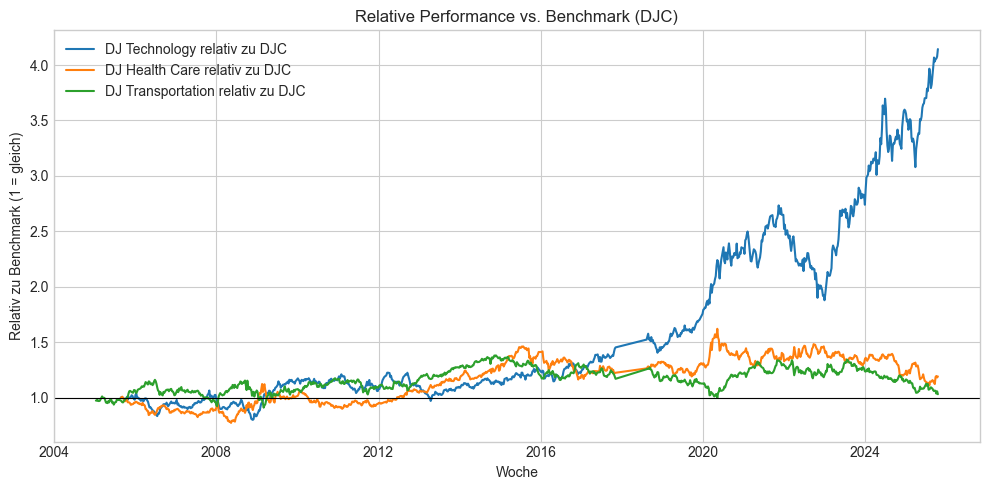

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Dow Jones Indizes ===
codes = ['DJC', 'DJUSTC', 'DJUSHC', 'DJT']   # Benchmark + Subindizes
bench = 'DJC'                                # Benchmark: Dow Jones Composite

# --- Daten vorbereiten ---
df = friday_df[friday_df['Indexcd'].isin(codes)].copy()
df['Clsidx'] = pd.to_numeric(df['Clsidx'], errors='coerce')
df.loc[df['Clsidx'] <= 0, 'Clsidx'] = np.nan

# Year/Week aus Date (YYYY-WW) ableiten (falls noch nicht vorhanden)
if 'Year' not in df.columns or 'Week' not in df.columns:
    df[['Year','Week']] = df['Date'].astype(str).str.split('-', expand=True).astype(int)

# Wochendatum (Montag jeder ISO-Woche)
df['WeekStart'] = df.apply(lambda r: pd.Timestamp.fromisocalendar(int(r['Year']), int(r['Week']), 1), axis=1)
df = df.sort_values(['Indexcd','WeekStart'])

# --- Wöchentliche Log-Returns ---
df['LogReturn'] = np.log(df['Clsidx']).groupby(df['Indexcd']).diff()

# --- Aggregation, falls es Duplikate je (Indexcd, WeekStart) gibt ---
pivot = (
    df.groupby(['Indexcd','WeekStart'])['LogReturn'].mean()
      .unstack('Indexcd')
      .sort_index()
)

# Nur Wochen behalten, in denen der Benchmark vorhanden ist
pivot = pivot.dropna(subset=[bench])

# --- Relative Performance: exp(cumsum(Subindex - Benchmark)) ---
rel = {}
names = {}
for code in codes:
    if code == bench or code not in pivot.columns:
        continue
    pair = pivot[[bench, code]].dropna()  # gemeinsame Wochen
    if pair.empty:
        continue
    ex_ret = (pair[code] - pair[bench]).cumsum()
    rel[code] = np.exp(ex_ret)            # Start = 1
    nm = df.loc[df['Indexcd']==code, 'IndexName']
    names[code] = (nm.dropna().iloc[0] if not nm.dropna().empty else code)

# --- Plot ---
plt.figure(figsize=(10,5))
for code, series in rel.items():
    plt.plot(series.index, series.values, label=f"{names[code]} relativ zu {bench}")
plt.axhline(1.0, color='black', linewidth=0.8)
plt.title(f"Relative Performance vs. Benchmark ({bench})")
plt.ylabel("Relativ zu Benchmark (1 = gleich)")
plt.xlabel("Woche")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
nasdaq_composite_df.head()

,Indexcd,IndexName,Date,Clsidx
0,NYA,NYSE Composite,2005-01,7057.51
21,SPX,S&P 500,2005-01,1186.19
25,DJT,DJ Transportation,2005-01,3636.78
40,DJU,DJ Utility,2005-01,324.68
49,IXUT,NQ Telecommunications,2005-01,191.90


In [21]:
import pandas as pd

# Helper-Funktion: ISO-Jahr/Woche → tatsächlicher Freitag (Wochentag=5)
def iso_yearweek_to_friday(y, w):
    return pd.Timestamp.fromisocalendar(int(y), int(w), 5)

# === USA: Nasdaq Composite (Indexcd = IXIC) ===
us = friday_df.loc[friday_df['Indexcd'] == 'IXIC', ['Date', 'Clsidx']].dropna().copy()

# Spalte Date ("YYYY-WW") in Jahr/Woche zerlegen → echtes Datum (Freitag)
us[['Year', 'Week']] = us['Date'].astype(str).str.split('-', expand=True).astype(int)
us['Date'] = us.apply(lambda r: iso_yearweek_to_friday(r['Year'], r['Week']), axis=1)

# Einheitliche Spalten und Sortierung
us = us[['Date', 'Clsidx']].rename(columns={'Clsidx': 'Close'}).sort_values('Date').drop_duplicates('Date')

# Speichern
us.to_csv('us_index.csv', index=False)
print(f"✅ us_index.csv gespeichert: {len(us)} Zeilen")
display(us.head())


✅ us_index.csv gespeichert: 1047 Zeilen


,Date,Close
85,2005-01-07,2088.61
253,2005-01-14,2087.91
427,2005-01-21,2034.27
647,2005-01-28,2035.83
794,2005-02-04,2086.66


In [110]:
import pandas as pd

# === Helper function: ISO year/week → Friday date ===
def iso_yearweek_to_friday(y, w):
    """Convert ISO year-week (YYYY, WW) to actual Friday date."""
    return pd.Timestamp.fromisocalendar(int(y), int(w), 5)

# === Target US subindices ===
target_codes = ['NDX', 'IXHC', 'IXID', 'NBI']

for code in target_codes:
    sub = friday_df.loc[friday_df['Indexcd'] == code, ['Date', 'Clsidx']].dropna().copy()
    
    # Split Date ("YYYY-WW") → Year / Week
    sub[['Year', 'Week']] = sub['Date'].astype(str).str.split('-', expand=True).astype(int)
    
    # Convert to actual Friday
    sub['Date'] = sub.apply(lambda r: iso_yearweek_to_friday(r['Year'], r['Week']), axis=1)
    
    # Standardize columns
    sub = sub[['Date', 'Clsidx']].rename(columns={'Clsidx': 'Close'}).sort_values('Date').drop_duplicates('Date')
    
    # Save to CSV
    out_name = f"{code}_index.csv"
    sub.to_csv(out_name, index=False)
    print(f"✅ {out_name} saved: {len(sub)} rows")

print("All three US subindices processed successfully.")


✅ NDX_index.csv saved: 1047 rows
✅ IXHC_index.csv saved: 1016 rows
✅ IXID_index.csv saved: 1045 rows
✅ NBI_index.csv saved: 1048 rows
All three US subindices processed successfully.
